# viz GT and preds meshes

In [24]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [395]:
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

from scipy.spatial.distance import cdist
from scipy.spatial.transform import Rotation as R
from pathlib import Path
import trimesh
import pyrender
from pyrender.constants import RenderFlags as rf
import h5py
import numpy as np
import torch
import os, os.path as osp
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from MinkowskiEngine.utils import sparse_quantize

from datasets.scannet.common import load_ply, create_color_palette
from datasets.scannet.utils_3d import adjust_intrinsic, make_intrinsic, load_intrinsic

In [26]:
def get_scan_name(scene_id, scan_id):
    return f'scene{str(scene_id).zfill(4)}_{str(scan_id).zfill(2)}'

In [27]:
root = Path('/mnt/data/scannet/scans')
version = 812
sceneid, scanid = 568, 0
print(sceneid, scanid)
scan_name = get_scan_name(sceneid, scanid)
print(scan_name)
gt_path = root / f'{scan_name}/{scan_name}_vh_clean_2.labels.ply'
print(gt_path)

568 0
scene0568_00
/mnt/data/scannet/scans/scene0568_00/scene0568_00_vh_clean_2.labels.ply


In [5]:
palette = np.array(create_color_palette(), dtype=int)

# Draw GT labels mesh

In [101]:
scene = trimesh.scene.scene.Scene() 

coords, old_colors, labels = load_ply(gt_path, read_label=True)
gt_vertex_colors = palette[labels]

# same vertices, new colors
gt_mesh_new = trimesh.Trimesh(vertices=coords, vertex_colors=gt_vertex_colors) #, faces=tr_mesh.faces, face_colors=tr_mesh.visual.face_colors)
gt_mesh_new.export('tmp.ply')
gt_mesh_new = trimesh.load('tmp.ply')
scene.add_geometry(gt_mesh_new)

scene.show()

In [ ]:
scene.camera_transform

array([[ 1.        ,  0.        ,  0.        ,  3.55862216],
       [ 0.        ,  1.        ,  0.        ,  3.6317338 ],
       [-0.        ,  0.        ,  1.        , 11.46799392],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [426]:
r.delete()

In [427]:
img_size = (640, 480)
render_intrinsic = make_intrinsic(1170.187988, 1170.187988, 647.75, 483.75)
# print(render_intrinsic)
render_intrinsic = adjust_intrinsic(render_intrinsic, [1296, 968], img_size)
render_focal = (render_intrinsic[0, 0], render_intrinsic[1, 1])
cx, cy = render_intrinsic[0, 2], render_intrinsic[1, 2]

render_cam = pyrender.IntrinsicsCamera(render_focal[0], render_focal[1], cx, cy, znear=0.4, zfar=20.0, name=None)
render_light = pyrender.DirectionalLight(color=[1.0, 1.0, 1.0], intensity=8.0)

r = pyrender.OffscreenRenderer(viewport_width=img_size[0],
                                viewport_height=img_size[1],
                                point_size=0.5)

(480, 640, 3)


(-0.5, 639.5, 479.5, -0.5)

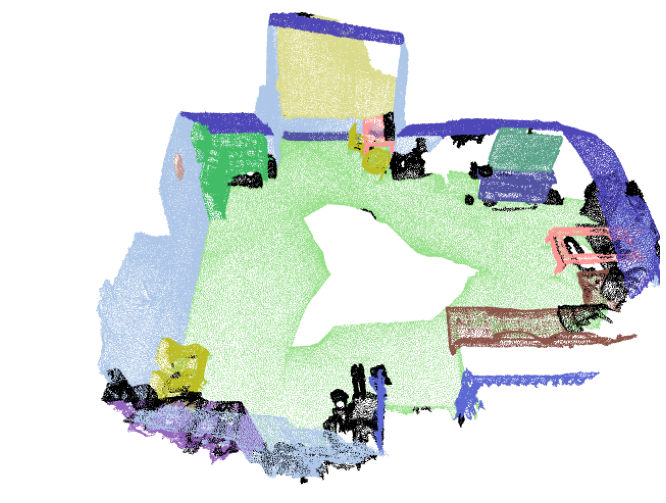

In [432]:
rot = R.from_euler('zyx', (0, 0, 40), degrees=True)
rmat = rot.as_matrix()
t = (2.5, -2, 8)
pose = np.array([
    [rmat[0][0], rmat[0][1], rmat[0][2], t[0]],
    [rmat[1][0], rmat[1][1], rmat[1][2], t[1]],
    [rmat[2][0], rmat[2][1], rmat[2][2], t[2]],
    [0, 0, 0, 1]
])

pymesh = pyrender.Mesh.from_points(coords, colors=gt_vertex_colors)
pyscene = pyrender.Scene()
pyscene.add(pymesh)
pyscene.add(render_cam, pose=pose)
pyscene.add(render_light, pose=pose)

rgb, _ = r.render(pyscene, rf.ALL_WIREFRAME | rf.FLAT )
print(rgb.shape)
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
plt.imshow(rgb)
plt.axis('off')


# Predictions on voxel centers

In [ ]:
scene_pred = trimesh.scene.scene.Scene() 

pred_path = f'/home/chandan/thesis/version_{version}_{scan_name}.ply'
pred_mesh = trimesh.load(pred_path)
print(pred_mesh)
scene_pred.add_geometry(pred_mesh)

scene_pred.show()

# Propagate voxel preds to vertices

In [ ]:
pred_path = f'/home/chandan/thesis/version_{version}_{scan_name}.ply'
# voxel-pred coords
coords_pred, colors_pred, _ = load_ply(pred_path, read_label=False)
print(coords.shape, coords_pred.shape)

# quantize the coords of the original mesh
unique_map, inverse_map = sparse_quantize(np.ascontiguousarray(coords), return_index=True, return_inverse=True,
                                                                quantization_size=0.05, return_maps_only=True)

# smaller set of coords
unique_coords = coords[unique_map]
print(unique_coords.shape)

# find all pairs distances between quantized coords and pred-voxel coords
distances = cdist(unique_coords, coords_pred)

# find the nearest pred-voxel to each quantized vertex and get its color
unique_coord_colors = []
for row in tqdm(distances):
    closest = row.argmin()
    closest_color = colors_pred[closest]
    unique_coord_colors.append(closest_color)

unique_coord_colors = np.array(unique_coord_colors, dtype=int)

# create a mesh using these colors and show it 
print(unique_coords.shape, unique_coord_colors.shape)
vertex_pred_colors = unique_coord_colors[inverse_map]
print(vertex_pred_colors.shape)
vertex_preds_mesh = trimesh.Trimesh(vertices=coords, vertex_colors=vertex_pred_colors)
vertex_preds_mesh.export('tmp.ply')
vertex_preds_mesh = trimesh.load('tmp.ply')

scene_pred_vertices = trimesh.scene.scene.Scene() 
scene_pred_vertices.add_geometry(vertex_preds_mesh)
scene_pred_vertices.show()